In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import csv 
import pickle
from scipy import stats
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations, rle2mask

## Extract train/test features from Image-Only model

In [3]:
# Get a mosaic DataPanel with the data.
df = build_cxr_df.out(load=True)
dp = get_dp(df)
dp.head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),img (CellColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...


In [4]:
model_pth = "/media/nvme_data/observational_results_10_2020/original/cxr/emmental_cam/cam_0/seed_0/best_model_target_cxr_val_accuracy.pth"

act_dp = get_cxr_activations(dp=dp, model_path=model_pth)


In [5]:
# train mask are points that have gaze
train_mask = dp["gaze_seq"].data != "nan"
act_dp[train_mask].head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (TensorColumn),img (ListColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),activation_block3 (NumpyArrayColumn),activation_block4 (NumpyArrayColumn)
0,1.2.276.0.7230010.3.1.4.8323329.1857.151787516...,378999 2 1018 8 1013 13 1009 15 1007 17 1006 1...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,1.0,train,"[(0.3002531741212215, 0.9348943074817682, 2), ...",[[ 0. 0. 0. 14. 2. 2. 1. 0.]\n [ 0. 0. ...,14.0,12.0,33.0,0.545455,1.0,'29',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
1,1.2.276.0.7230010.3.1.4.8323329.1219.151787516...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,1.0,train,"[(0.3135288701615107, 0.5596042556980056, 2), ...",[[0. 0. 0. 1. 3. 0. 0. 0.]\n [0. 0. 0. 3. 3. 2...,7.0,19.0,46.0,0.369565,1.0,'39',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
2,1.2.276.0.7230010.3.1.4.8323329.2118.151787517...,591104 8 1011 18 1001 26 993 32 988 36 986 37 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,1.0,train,"[(0.1227472372112641, 0.5808183519907184, 3), ...",[[ 0. 0. 0. 0. 4. 1. 0. 1.]\n [ 0. 0. ...,10.0,23.0,81.0,0.395062,1.0,'43',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
3,1.2.276.0.7230010.3.1.4.8323329.2027.151787517...,500845 25 992 38 983 41 980 44 978 46 975 49 9...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.3294461311053661, 0.5748967530438639, 4), ...",[[ 0. 0. 4. 1. 10. 8. 0. 0.]\n [ 0. 0. ...,11.0,21.0,78.0,0.641026,1.0,'50',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
4,1.2.276.0.7230010.3.1.4.8323329.1972.151787517...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,train,"[(0.25439717874245193, 0.6421419414319375, 2),...",[[ 0. 0. 5. 0. 0. 2. 0. 0.]\n [ 0. 1. ...,10.0,22.0,75.0,0.266667,0.0,'53',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"


In [6]:
# test mask are points that do not have gaze and have chest tube labels
test_mask = np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))
act_dp[test_mask].head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (TensorColumn),img (ListColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),activation_block3 (NumpyArrayColumn),activation_block4 (NumpyArrayColumn)
0,1.2.276.0.7230010.3.1.4.8323329.32395.15178751...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,test,nan,nan,NaN,NaN,NaN,NaN,NaN,'7',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
1,1.2.276.0.7230010.3.1.4.8323329.12084.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,test,nan,nan,NaN,NaN,NaN,NaN,NaN,'26',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
2,1.2.276.0.7230010.3.1.4.8323329.13325.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,test,nan,nan,NaN,NaN,NaN,NaN,NaN,'36',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
3,1.2.276.0.7230010.3.1.4.8323329.11640.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,test,nan,nan,NaN,NaN,NaN,NaN,NaN,'47',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"
4,1.2.276.0.7230010.3.1.4.8323329.14529.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,0.0,test,nan,nan,NaN,NaN,NaN,NaN,NaN,'66',"torch.Tensor(shape=torch.Size([3, 224, 224]))",<PIL.Image.Image image mode=L size=1024x1024 a...,0,"np.ndarray(shape=(2,))","np.ndarray(shape=(1024, 14, 14))","np.ndarray(shape=(2048, 7, 7))"


In [7]:
# act_dp_ = get_cxr_activations.out(run_id=35,load=True)
# act_dp_.head()

In [102]:
gaze_name = "unique"
image_feats_train = act_dp["activation_block4"][train_mask].reshape(-1,2048,49).mean(2)
tube_labels_train = act_dp["chest_tube"][train_mask]
pmx_labels_train = act_dp["pmx"][train_mask]
probs_train = act_dp["probs"][train_mask].data[:,1]
gaze_feature = act_dp[f"gaze_{gaze_name}"][train_mask]

image_feats_test = act_dp[test_mask]["activation_block4"].reshape(-1,2048,49).mean(2)
tube_labels_test = act_dp["chest_tube"][test_mask]
pmx_labels_test = act_dp["pmx"][test_mask]
probs_test = act_dp["probs"][test_mask].data[:,1]

## train few-shot LR models with gaze features

In [103]:
k = 20
label_mask = pmx_labels_train == 1
label_mask_test = pmx_labels_test > -1


thresh1 = np.sort(gaze_feature[label_mask])[-k]
thresh2 = np.sort(gaze_feature[label_mask])[k]
label_mask_1 = gaze_feature[label_mask] >= thresh1
label_mask_0 = gaze_feature[label_mask] <= thresh2

X_train = np.concatenate((image_feats_train[label_mask][label_mask_1],image_feats_train[label_mask][label_mask_0]))
y_train = np.array([1]*label_mask_1.sum() + [0]*label_mask_0.sum())

print(X_train.shape)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
test_slices = clf.predict(image_feats_test[label_mask_test])
print(f"{test_slices.sum()}/{len(test_slices)}")


(55, 2048)
149/1000


## View performance gaps in test set

In [104]:
thresh = 0.3 #373 # this threshold achieves 0.55 recall for overall
preds_test = (probs_test > thresh)
overall_acc = (preds_test[label_mask_test] == pmx_labels_test[label_mask_test]).mean()
#print(f"Overall accuracy for class: {100*overall_acc:.2f}")
print(f"Overall AUROC: {100*roc_auc_score(pmx_labels_test, probs_test):.2f}")


mask1 = test_slices.astype(bool)
acc_0 = (preds_test[label_mask_test][mask1] == pmx_labels_test[label_mask_test][mask1]).mean()
#print(f"Accuracy for class on slice 0: {100*acc_0:.2f}")
print(f"High {gaze_name} AUROC: {100*roc_auc_score(pmx_labels_test[mask1], probs_test[mask1]):.2f}")


mask2 = (1-test_slices).astype(bool)
acc_1 = (preds_test[label_mask_test][mask2] == pmx_labels_test[label_mask_test][mask2]).mean()
#print(f"Accuracy for class on slice 1: {100*acc_1:.2f}")
print(f"Low {gaze_name} AUROC: {100*roc_auc_score(pmx_labels_test[mask2], probs_test[mask2]):.2f}")


Overall AUROC: 90.86
High unique AUROC: 80.11
Low unique AUROC: 89.78


## Quantitative analysis with segmentation masks

In [105]:
rle_1 = act_dp[test_mask]["encoded_pixels"][mask1]
rle_2 = act_dp[test_mask]["encoded_pixels"][mask2]

In [106]:
segmasks_1 = np.array([rle2mask(rle,1024,1024).T for rle in rle_1 if rle!='-1'])
segmasks_2 = np.array([rle2mask(rle,1024,1024).T for rle in rle_2 if rle!='-1'])


### Abnormal area

In [107]:
abn_size1 = segmasks_1.mean((1,2))
abn_size2 = segmasks_2.mean((1,2))

print(f"Average abnormal area for high {gaze_name}: {abn_size1.mean():.4f}")
print(f"Average abnormal area for low {gaze_name}: {abn_size2.mean():.4f}")

from scipy.stats import ttest_ind

print(f"p-value: {ttest_ind(abn_size1,abn_size2)[1]:.4f}")


Average abnormal area for high unique: 0.0094
Average abnormal area for low unique: 0.0128
p-value: 0.0737


### Abnormal location

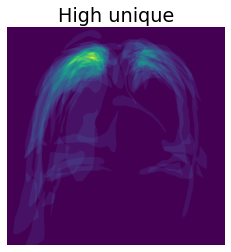

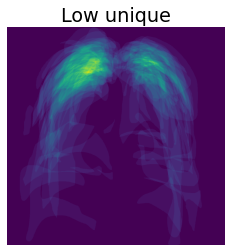

In [108]:
# take average across all examples in slice and imshow the differences
abn_locmap_1 = segmasks_1.mean(0)
abn_locmap_2 = segmasks_2.mean(0)

# min_val = min(abn_locmap_1.min(),abn_locmap_2.min())
# max_val = max(abn_locmap_1.max(),abn_locmap_2.max())

# abn_locmap_1 -= min_val
# abn_locmap_1 /= max_val

# abn_locmap_2 -= min_val
# abn_locmap_2 /= max_val

plt.title(f"High {gaze_name}")
plt.imshow(abn_locmap_1)
plt.axis("OFF")
# for i in range(abn_locmap_1.shape[0]):
#     for j in range(abn_locmap_1.shape[1]):
#         text = plt.text(j, i, f"{abn_locmap_1[i, j]:.1f}", ha="center", va="center", color="w")
plt.show()

plt.title(f"Low {gaze_name}")
plt.imshow(abn_locmap_2)
plt.axis("OFF")
# for i in range(abn_locmap_1.shape[0]):
#     for j in range(abn_locmap_1.shape[1]):
#         text = plt.text(j, i, f"{abn_locmap_2[i, j]:.1f}", ha="center", va="center", color="w")
plt.show()



## Are slices points the expert got wrong?

In [109]:
# we can only check this in our train set that has gaze data
# so as a start lets compare the top K vs. bottom K

expert_labels = act_dp["expert_label"][train_mask][label_mask]
expert_labels_mask1 = expert_labels[label_mask_1] # top K feats
expert_labels_mask0 = expert_labels[label_mask_0] # bottom K feats
overall_mask = np.logical_or(label_mask_1,label_mask_0)
expert_labels_ = expert_labels[overall_mask]
# since label_mask is constrained to positive points, the average expert_labels_mask* is the recall
print(f"Expert recall overall: ratio: {int(expert_labels_.sum())}/{len(expert_labels_)}, mean: {expert_labels_.mean():.2f}")
print(f"Expert recall on high {gaze_name}: ratio: {int(expert_labels_mask1.sum())}/{len(expert_labels_mask1)}, mean: {expert_labels_mask1.mean():.2f}")
print(f"Expert recall on low {gaze_name}: ratio: {int(expert_labels_mask0.sum())}/{len(expert_labels_mask0)}, mean: {expert_labels_mask0.mean():.2f}")



Expert recall overall: ratio: 38/55, mean: 0.69
Expert recall on high unique: ratio: 16/29, mean: 0.55
Expert recall on low unique: ratio: 22/26, mean: 0.85
